# Assignment 1

## Part 1. Get Data

### Data 1:

We first define a function that can download each page of a wikipedia category and save it to a file

In [1]:
import urllib2
import json
import requests
import codecs
import unicodedata
import numpy as np
import re

In [2]:
def query(request):
    request['action'] = 'query'
    request['format'] = 'json'
    lastContinue = {'continue': ''}
    while True:
        req = request.copy()
        req.update(lastContinue)
        result = requests.get('http://en.wikipedia.org/w/api.php',params=req).json()
        if 'query' in result: yield result['query']
        if 'continue' not in result: break
        lastContinue = result['continue']

def download_wiki_category(category_name,file_name):
    #Category List
    content = []
    for result in query({'list':'categorymembers','cmtitle':category_name}):
        content.append(result)

    pageidList = []
    titleList = []
    p=0
    for a in content:
        dataList = a['categorymembers']
        for d in dataList:
            p=p+1
            pageidList.append(str(d['pageid']))
            titleList.append(d['title'])

    #Content
    content = []
    i=0
    while(i<len(pageidList)-50):
        ids = ('|' .join(pageidList[i:i+50]))
        for result in query({'prop':'revisions','rvprop':'content','pageids':ids}):
            content.append(result)
        i=i+50
    ids = ('|' .join(pageidList[i:]))
    for result in query({'prop':'revisions','rvprop':'content','pageids':ids}):
        content.append(result)
    i = 0
    array = []
    for con in content:
        for ido in pageidList:
            array.append(ido)
            if ido in con['pages'].keys():
                i=i+1

    #Parse and save
    a=0;
    saveDict = dict()
    while a<len(pageidList):
        for con in content:
            if(pageidList[a] in con['pages'].keys()):
                saveDict[titleList[a]] = con['pages'][pageidList[a]]
                a=a+1
    fileObject = codecs.open(file_name,'w','utf-8-sig')

    json.dump(saveDict,fileObject)

    fileObject.close()

We now use this function to download both the superheroes and supervillains to files on the local HD

<i>Question: Download all Marvel super-hero pages from wikipedia. Save to your hard drive.</i>

In [3]:
download_wiki_category('Category:Marvel_Comics_superheroes','MarvelHeroesAssignment.json')

<i>Question: Download all Marvel super-villain pages from wikipedia. Save to your hard drive.</i>

In [4]:
download_wiki_category('Category:Marvel_Comics_supervillains','MarvelVillainsAssignment.json')

<i>Question: Create three data-sets with the page contents that you can easily load into Python. Heroes, Villains, Ambiguous.</i>

We load the files of the superheroes and supervillians, and divide the data into three exclusive categories. Heroes, Villains, and those that are both a hero and a supervillian.

In [3]:
fileObject = codecs.open('MarvelHeroesAssignment.json','r','utf-8-sig')

superheroes = json.load(fileObject)

fileObject.close()

fileObject = codecs.open('MarvelVillainsAssignment.json','r','utf-8-sig')

supervillains = json.load(fileObject)

fileObject.close()

print 'Sum of all characters: '+ str(len(superheroes)+len(supervillains))

ambigious = dict()
for hero in superheroes:
    if hero in supervillains:
        ambigious[hero] = superheroes[hero]
for gecko in ambigious:
    superheroes.pop(gecko)
    supervillains.pop(gecko)
print 'sum of all characters '+str(len(superheroes)+len(supervillains)+len(ambigious))+'    Equivalent sum from before removal '+str(len(superheroes)+len(supervillains)+len(ambigious)*2)

Sum of all characters: 2189
sum of all characters 2025    Equivalent sum from before removal 2189


As we can see from these sums we have not lost any data in this transformation

### Data 2:

<i>Question: Now, show that you can download the list of top cities in USA and their locations from Wikipedia.</i>

<i>Question: Use the Query API to obtain the content of the page http://en.wikipedia.org/wiki/List_of_United_States_cities_by_population</i>

We begin by using the same query function as before to download the wiki page containing the data

In [4]:
title = 'List_of_United_States_cities_by_population'
content = []
for result in query({'prop':'revisions','rvprop':'content','titles':title}):
    content.append(result)

<i>Question: You will need to parse the table to extract the city-locations</i>

We extract the raw data string from the json structure, and get the table of the cities by population using string operations.

In [5]:
data2 = content[0]['pages']['1649321']['revisions'][0]['*']
temp = data2[data2.index('|-')+2:data2.index('|}')]
data2clean = temp[temp.index('|-')+2:]

<i>Question: Extract the cities locations.</i>

We now extract the names, links, and locations of each city respectively by using string operations

In [6]:
citynames = []
citylocations = []
citylinks = []
for city in data2clean.split('|-'):
    temp2 = re.findall(r'\[\[(.*?)\]\]',city)[0]
    if '|' in temp2:
        temp3 = temp2[temp2.index('|')+1:]
        temp2 = temp2[:temp2.index('|')]
    else:
        temp3 = temp2
    citynames.append(temp3)
    citylinks.append(temp2)
    citylocations.append(city.split('|')[-1])

<i>Question: Print the first 10 links inside your Notebook. </i><br>As per the assignment we print the first 10 links

In [7]:
for a in range(10):
    print citylinks[a]


New York City
Los Angeles
Chicago
Houston
Philadelphia
Phoenix, Arizona
San Antonio
San Diego
Dallas
San Jose, California


<i>Question: How many cities did you manage to parse?</i><br>The amount of cities that are parsed

In [8]:
len(citynames)

295

<i>Question: Plot the location of all cities using matplotlib plot function. Does the shape make sense?</i><br>We now parse the location strings into N and W value arrays to prepare them for visualization. First we define a function that can parse a single location string.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def parseLocation(string):
    loc = string.split('N')
    N = loc[0].strip()[0:-1]
    W = '-'+loc[1].strip()[0:-2]
    return [N,W]

Secondly we use this function on all of the location strings. Note that one of the locations is excluded since the data for this is corrupted

In [11]:
N_array = []
W_array = []
for loc in citylocations[:284]+citylocations[285:]:
    point = parseLocation(loc)
    N_array.append(point[0])
    W_array.append(point[1])

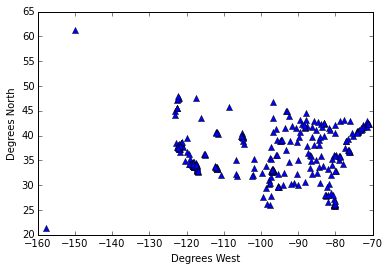

In [12]:
plt.plot(W_array,N_array,'^')
plt.ylabel('Degrees North')
plt.xlabel('Degrees West')
plt.show()

The plot shows a very nice contour of USA.

## Part 2.

### Viz 1:

We count the number of characters in each superhero page and visualize it using a histogram

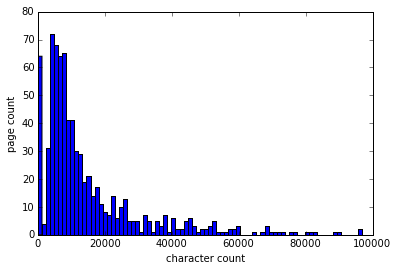

In [19]:
counts = []
names = []
for hero in superheroes:
    counts.append(superheroes[hero]['revisions'][0]['*'].count(''))
    names.append(hero)
plt.hist(counts,bins=80)
plt.ylabel('page count')
plt.xlabel('character count')
plt.show()

The plot clearly shows a tendency towards lower values of character count in the pages. The decline in pages with increased character counts seem to almost follow a normal distribution. We can also spot a relatively large group of (maybe) outliers that are 0 or very close. These are probably stub articles and should maybe be culled. We now plot the CDF.

In [20]:
def cdfPlot(countArray):
    sumDN = 0.
    sumN = 0.
    for number in countArray:
        sumDN = sumDN + number
    scounts = []
    for number in np.sort(countArray):
        sumN = sumN + number
        scounts.append(sumN / sumDN)
    plt.plot(np.sort(countArray),scounts)
    plt.xlabel('character count')
    plt.ylabel('P(X)')
    plt.show()

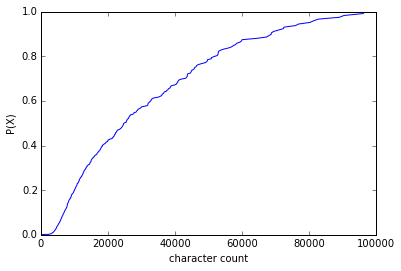

In [21]:
cdfPlot(counts)

The plot shows a CDF that is arguably reminicant of the CDF of a normal distribution, which further strengthens our claim. 

We now plot the 10 largest articles in a bar chart

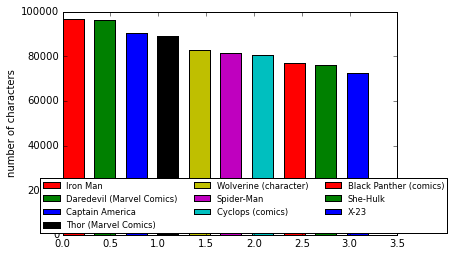

In [22]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

revSorted = np.sort(counts)[::-1]
i=0
longHeroes = []
longNames = []
longLBoxes = []
colors = ['r','g','b','k','y','m','c','r','g','b']
n = 10
width = 0.33
XGroups = np.arange(1)
while i<n:
    index = counts.index(revSorted[i])
    longNames.append(names[index])
    longHeroes.append(plt.bar(XGroups+i*width,counts[index],width/3*2,color=colors[i]))
    longLBoxes.append(longHeroes[i][0])
    i+=1

plt.ylabel("number of characters")
plt.legend((longLBoxes),(longNames),loc='lower center',ncol = 3,prop=fontP,bbox_to_anchor=(0.54,-0.01))
plt.show()

This list of course includes marvel characters with large fanbases and roles in popular culture. Several are starred in large budget movies. Then again there are also some surprising results

### Viz 2:

We now extract the infobox from the hero pages if it exists

In [23]:
def get_infoboxes(array):
    infoBox = []
    for name in array:
        result = re.findall(r'({{Superherobox)((.[^}}]|\n)*.)(}})',array[name]['revisions'][0]['*'])
        if not(result==[]):
            infoBox.append(result[0][1])
    return infoBox
infoBoxes = get_infoboxes(superheroes)

We extract the debut years from these infoboxes. We discard the data if it is missing and if there are several debut years the earliest is chosen as representative data

In [24]:
debutBin=[]

for info in infoBoxes:
    s1 = re.findall(r'debut.*',info)
    if not(s1==[]):
        years = re.findall(r'[^#](\d\d\d\d\b)',s1[0])
        if not(years==[]):
            debutBin.append(int(min(years)))

We visualize this data. We have chosen a histogram of debuts over time, since this is a good representation of how many characters are debuting the different years

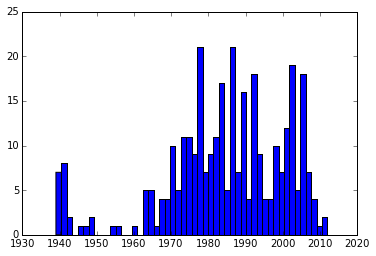

In [25]:
plt.hist(debutBin,bins=50)
plt.show()

In [26]:
infoBoxes2 = get_infoboxes(supervillains)

In [27]:
debutBin2=[]

for info in infoBoxes2:
    s1 = re.findall(r'debut.*',info)
    if not(s1==[]):
        years = re.findall(r'[^#](\d\d\d\d\b)',s1[0])
        if not(years==[]):
            debutBin2.append(int(min(years)))

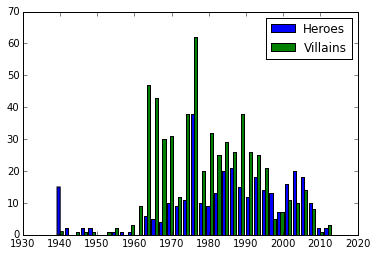

In [28]:
#plt.hist(debutBin2,bins=50)
plt.hist([debutBin,debutBin2],bins=35)
plt.legend(['Heroes','Villains'])
plt.show()

It would seem from this data that the number of debutant heroes/villains approximate each other over time. This could indicate a trend from before superheroes where had to face off against several different evil villains (the freak of the week concept), toward superheroes having one major enemy that they never can seem to completely vanquish (the nemesis concept).

or it could be a coincidence. who knows...

### Viz 3:

We utilize a regex matching scheme to get all of the aliances of each infobox out in as clean a form as possible

In [29]:
alianceList = dict()

for iB in infoBoxes:
    s1 = re.findall(r'alliances ?=(.*)',iB)
    if not(s1==[]): 
        s2 = re.split(r'<\s*br\s*/>|<\s*br\s*>',s1[0])
        for group in s2:
            s3 = re.findall(r'\[\[([^\]]*)',group)
            if not(s3==[]):
                s4 = s3[0].split('|')
                s4 = s4[len(s4)-1]
                if s4 in alianceList:
                    alianceList[s4] = alianceList[s4] + 1
                else:
                    alianceList[s4] = 1

We visualize this as a histogram as well

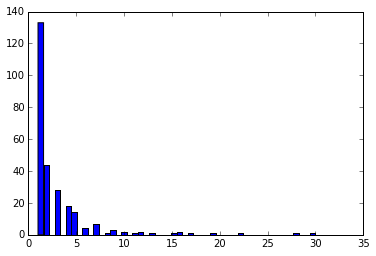

In [30]:
plt.hist(alianceList.values(),bins=50)
plt.show()

We can clearly see that most of these 'so-called' aliances have 1 members... This (kind of amusing) result likely stems from the fact that aliances such as "Stark Industries", "the Stark Enterprise", and "Stark Enterprises" are counted seperately

### Viz 4:

<i>Question: For each superhero page, extract all the links.</i><br>We make a method to extract all of the internal wiki links with the format of [[text|link]] and another method to extract all of the external links (http or https).

In [19]:
"""This method returns the left side of a link"""
def link_left_side(link):
    return link.split('|')[0]

"""This methods returns the internal wiki links"""
def get_wiki_links(text):
    links = re.findall("\[\[([^\]]*)\]\]",text[0]['*'])
    clean_links = []
    for link in links:
        clean_links.append(link_left_side(link))
    return clean_links

"""This methods returns all the external links"""
def get_eksternal_links(text):
    links = re.findall("(http|https)(://)(.*)",text[0]['*']) 
    return links

link_array = []
exlink = []
for hero in superheroes:
    for link in get_wiki_links(superheroes[hero]['revisions']):
        link_array.append(link)
    for link in get_eksternal_links(superheroes[hero]['revisions']):
        exlink.append(link[2])

<i>Question: For each of the cities in the dataset from Data 2, count how many times the superheroes link to them. For example, if the Superman page links to New York City twice, and the Magneto page links to New York City once, the final count to New York City will be 3.</i><br>We search through the collected links to check how many times a link in the citylinks array occurs

In [20]:
link_search = dict()
for link in link_array:
    if link in citylinks:
        if link in link_search.keys():
            link_search[link] = link_search[link]+1
        else:
            link_search[link] = 1

<i>Question: What are the counts for all the cities? Report your results with a bar chart.</i>
We plot our results of the counts of all the cities.

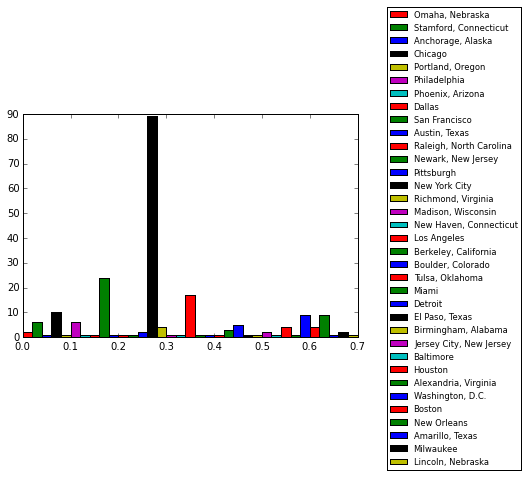

In [40]:
fontP = FontProperties()
fontP.set_size('small')

names = []
l_boxes = []

i=0
j=0
colors = ['r','g','b','k','y','m','c','r','g','b']
n = len(link_search)
width = 0.03
XGroups = np.arange(1)
for city in link_search:
    names.append(city)
    plot = plt.bar(XGroups+i*width/3*2+j*10*width/3*2,link_search[city],width/3*2,color=colors[i])
    l_boxes.append(plot[0])
    i+=1
    if i >= len(colors):
        i = 0
        j+=1

plt.legend((l_boxes),(names),ncol = 1,prop=fontP,bbox_to_anchor=(1.5, 1.5))
plt.show()

<i>Question: Plot a map using a Basemap</i>

In [26]:
from mpl_toolkits.basemap import Basemap

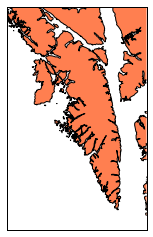

In [27]:
map = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-136.25, llcrnrlat=56.0,
    urcrnrlon=-134.25, urcrnrlat=57.75)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
 
plt.show()

<i>Question: Change the map boundaries to the USA using Basemap(projection='merc', lat_0 = 57, lon_0 = -135, resolution = 'h', area_thresh = 0.1, llcrnrlon=-133.86, llcrnrlat=11.35, urcrnrlon=-56.69, urcrnrlat=50.68). Plot the empty USA map</i>

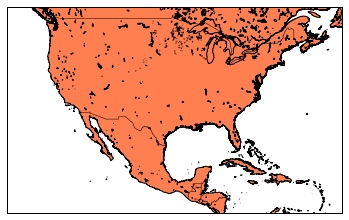

In [15]:
map = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-133.86, llcrnrlat=11.35,
    urcrnrlon=-56.69, urcrnrlat=50.68)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
 
plt.show()

<i>Question: Visualize all the city-locations you found in Exercise A on a new USA map using the matplotlib plot method</i>

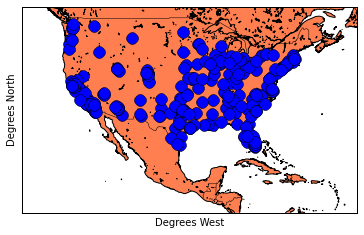

In [16]:
m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'l', area_thresh = 0.1,
    llcrnrlon=-133.86, llcrnrlat=11.35,
    urcrnrlon=-56.69, urcrnrlat=50.68)
 
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

N_array = []
W_array = []
for loc in citylocations[:284]+citylocations[285:]:
    point = parseLocation(loc)
    N_array.append(float(point[0]))
    W_array.append(float(point[1]))

x,y = m(np.array(W_array),np.array(N_array))
m.plot(x,y,'bo', markersize=12)
plt.ylabel('Degrees North')
plt.xlabel('Degrees West')
 
plt.show()

<i>Question: Visualize only the city-locations that were mentioned in superhero pages that you found in Exercise B1 (again using the matplotlib plot method). Do you see a pattern in the spatial distribution?</i><br>The pattern looks like there are several different cities that has a super villian, but doesn't have a super hero, also it looks like all the super heroes are concentrated around the major metropolisis around USA.

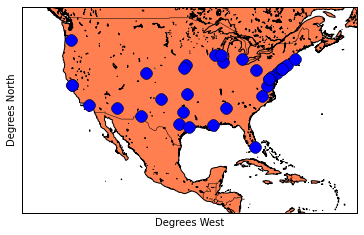

In [21]:
m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'l', area_thresh = 0.1,
    llcrnrlon=-133.86, llcrnrlat=11.35,
    urcrnrlon=-56.69, urcrnrlat=50.68)
 
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

indices = []
for city in link_search:
    indices.append(citylinks.index(city))
  
N_array = []
W_array = []
for index in indices:
    loc = citylocations[index]
    point = parseLocation(loc)
    N_array.append(float(point[0]))
    W_array.append(float(point[1]))

x,y = m(np.array(W_array),np.array(N_array))
m.plot(x,y,'bo', markersize=12)
plt.ylabel('Degrees North')
plt.xlabel('Degrees West')
 
plt.show()

<i>Question: Visualize only the cities locations that were mentioned in the superheroes pages using the matplotlib hexbin method as follows: hexbin(x, y, gridsize=40, bins='log', cmap='YlOrRd', edgecolors='none', alpha=0.75). Do you see a different pattern compared to previously?</i>

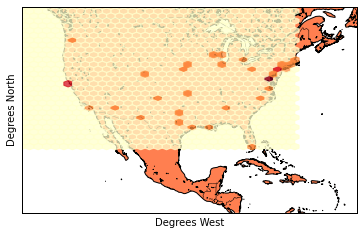

In [188]:
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

m.hexbin(x, y, gridsize=40, bins='log', cmap='YlOrRd', edgecolors='none', alpha=0.75,zorder = 2)
plt.ylabel('Degrees North')
plt.xlabel('Degrees West')
 
plt.show()

<i>Question: Visualize only the cities locations that were mentioned in the superhero pages using the plot method once again. This time, however, use the markersize parameter to make each dot proportional to the square root of the count for each city. Does this map provides different information than the previous ones?</i><br>In this plot it's clear to see that the superheroes are concentrated around the east side, but also in the major cities at the west coast.

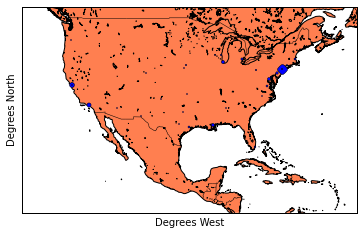

In [25]:
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

indices = []
for city in link_search:
    index = citylinks.index(city)
    loc = citylocations[index]
    point = parseLocation(loc)
    x,y = m(np.array(float(point[1])),np.array(float(point[0])))
    m_size = np.sqrt(float(link_search[city]))
    # m_size = np.log(link_search[city])
    m.plot(x,y,'bo', markersize=m_size)
    
plt.ylabel('Degrees North')
plt.xlabel('Degrees West')
 
plt.show()

<i>Question: Why do you think we recommend scaling by the square root?</i>

The reason why we scale by the square root of the count of cities, is in order to normalize our data. Also this makes it gives a more realistic way view of the cities.